# AGH Modelling of Physical Systems Lab 4 (2025 March 25th)
Professor - Sylwester Arabas (sylwester.arabas@agh.edu.pl) 

### Author

Wojciech Neuman (neuman@student.agh.edu.pl)

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import  show_anim

## Advection-diffusion equation

The advection-diffusion equation models how a quantity like pollutant concentration $C$ changes over time in a moving and diffusing medium. It combines the effects of transport due to fluid motion with spreading caused by diffusion. 

The formula for one-dimensional advection-diffusion equation is:

$$
\frac{\partial C}{\partial t} + u \frac{\partial C}{\partial x} - D \frac{\partial^2 C}{\partial x^2} = 0
$$

Here, $u$ represents the velocity of the fluid flow, and $D$  denotes the diffusion coefficient of the substance within the fluid.

In [146]:
def rmse_error(numeric, true_value):
    return np.sqrt(np.mean((numeric - true_value) ** 2)) # From lab-3

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
        
    
    def __radd__(self, other):
        return slice(other.start + self.add, other.stop + self.add)
    
    def __rsub__(self, other):
        return slice(other.start - self.sub, other.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

### Define x-related values

In [147]:
x_min = -2.05
x_max = 6.05
nx = 100
dx = (x_max - x_min) / nx

x = np.linspace(x_min, x_max, nx, endpoint=False)

### Define constants

In [148]:
D = 0.05
u = 3.0
M = 0.03

### Define t-related values

In [149]:
t_min = 0.01
t_max = 2.01
nt = 1000
dt = (t_max - t_min) / nt

### Analytical Solution Overview

Consider the one-dimensional advection-diffusion equation under the following setup:

- Spatial domain: $x$
- Time domain: $ t \geq 0 $
- Homogeneous Dirichlet boundary conditions:  
  $ C(0, t) = C(1, t) = 0 $ for all $ t \geq 0 $
- Initial condition defined as a sine profile:  
  $ C(x, 0)$ = $sinx $
- Constant coefficients:  
  $ D $ – diffusion coefficient,  
  $ u $ – advection velocity,
  $ M $ - is a total amount of substance (unit: $kg$),

Under these assumptions, the problem admits an exact (analytical) solution, which evolves in time according to:

$$
C(x, t) = \exp\left( -\left( \frac{u^2}{4D} + \pi^2 D \right) t \right) \sin(\pi x)
$$

This solution illustrates how the initial concentration profile decays exponentially over time due to both advective transport and diffusive spreading, at the same time maintaining the spatial structure of sinusoidal nature.


In [150]:
def analytical_solution(x, t, M, D, u) -> np.ndarray:
    return M / np.sqrt(4 * np.pi * D * t) * np.exp(- (x - u * t)**2 / (4 * D * t))

psi_analytical = analytical_solution(x, t_min, M, D, u)

# print(psi_analytical.shape)
# print(psi_analytical[0:1])

### Numerical Solution Summary

To solve the advection-diffusion equation numerically, we use a modified upwind scheme. Instead of treating advection and diffusion separately, we merge them into a single effective velocity:

$$
C_i = \frac{\Delta t}{\Delta x} \left( u - D \cdot \frac{\partial_x C}{C} \right)
$$

This dynamic Courant number reflects both transport mechanisms and is updated at every step. The flux is then computed using the upwind method, allowing stable evolution of the solution over time.

This approach efficiently captures the decay and shift of the initial sine-shaped concentration profile.


In [151]:
psi_temp = psi_analytical.copy()

i = slice(1, nx-1)
im = slice(1, nx)

C = np.zeros(len(psi_temp) - 1)

result = list()
result.append(psi_analytical.copy())

for _ in range(nt):

  C[im - hlf] = dt / dx * (u - D * (psi_temp[im] - psi_temp[im - one]) / dx * 2 / (psi_temp[im] + psi_temp[im - one] + 1e-10))

  psi_temp[i] -= F(psi_temp[i], psi_temp[i + one], C[i + hlf]) - F(psi_temp[i - one], psi_temp[i], C[i - hlf])

  result.append(psi_temp.copy())

### Visualization of the solution

To better understand how the concentration evolves with time and space, we generate a dynamic visualization. This allows us to observe how the initial profile spreads and shifts due to the combined effects of diffusion and advection.

Additionally we perform a comparison with analytical solution, at the same time calculating RMSE.

/var/folders/9_/vrjvn4xx4fd31flw29nx6bpr0000gp/T/ipykernel_31269/1473348519.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



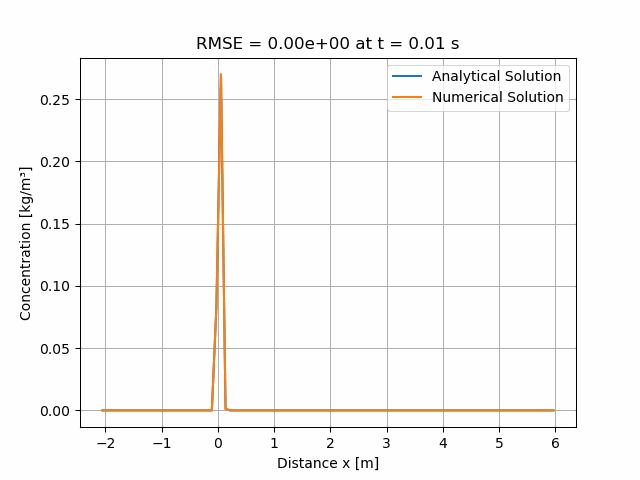

HTML(value="<a href='./tmpj2473jsq.gif' target='_blank'>./tmpj2473jsq.gif</a><br>")

In [152]:
frames = list(range(0, nt, 10))
rmse_log = {}
figures = []

errors = []

for frame in frames:
    current_t = t_min + frame * dt

    analytical = analytical_solution(x, current_t, M, D, u)
    numerical = result[frame]

    error = rmse_error(numerical, analytical)
    errors.append(error)
    rmse_log[frame] = error

    fig = plt.figure()
    plt.plot(x, analytical, label='Analytical Solution')
    plt.plot(x, numerical, label='Numerical Solution')
    plt.title(f'RMSE = {error:.2e} at t = {current_t:.2f} s')
    plt.xlabel('Distance x [m]')
    plt.ylabel('Concentration [kg/m³]')
    plt.legend()
    plt.grid(True)

    figures.append(fig)

show_anim(lambda i: figures[i], range(len(frames)))

In [153]:
# Mean RMSE
mean_rmse = np.mean(errors)
print(f'Mean RMSE: {mean_rmse:.2e}')

Mean RMSE: 4.65e-03


Although the RMSE is numerically small, the relative error is noticeably - especially around the peak. 

Interestingly, the RMSE tends to decrease as time increases, yet the relative aproximation of the analytical solution becomes worse. This is likely due to the numerical method smoothing the peak faster than the true solution.